
**Практика 3: Атака Carlini-Wagner (CW) на модели ИИ**

Белов Владимир Станиславович ББМО-01-23

**Цель задания:**
Изучить одну из наиболее мощных атак на модели ИИ — атаку Carlini-Wagner (CW). Задача — научиться использовать CW для создания противоречивых примеров и исследовать влияние этой атаки на обученные модели

**Задачи:**
 1. Загрузить ранее обученную модель на датасете MNIST.
 2. Изучить теоретические основы атаки Carlini-Wagner.
 3. Реализовать атаку CW с помощью фреймворка Foolbox.
 4. Оценить точность модели на противоречивых примерах и сравнить с результатами на обычных
 данных.



**Шаг 1:** Загрузим обученные модели и данных MNIST
из предыдущей практики для дальнейшего анализа.


In [6]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()
# Нормализация данных
test_images = test_images / 255.0
# Преобразование меток в формат one-hot
test_labels = to_categorical(test_labels, num_classes=10)
# Загрузка обученной модели
model = tf.keras.models.load_model('/content/sample_data/mnist_model.h5')
# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9751 - loss: 0.0808
Test accuracy on clean images: 0.9779999852180481


**Шаг 2:** Установка Foolbox и запуск CW-атаки

Атака Carlini-Wagner (CW) — это одна из наиболее эффективных атак, созданных для введения моделей в заблуждение. Для реализации атаки Carlini-Wagner будем использовать фреймворк Foolbox, который
 предоставляет удобные методы для выполнения различных атак на модели ИИ

In [7]:
!  pip install foolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.0 MB/s eta 0:00:00


Реализация атаки Carlini-Wagner:


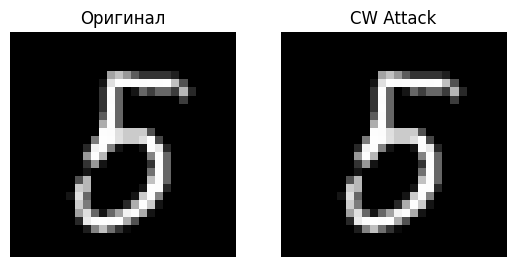

In [51]:
import foolbox as fb
import numpy as np

# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

# Конвертация и выборка
image = tf.convert_to_tensor(test_images[45], dtype=tf.float32)[None, ...]
label = np.argmax(test_labels[0]) # Получаем индекс класса
label = tf.convert_to_tensor(label, dtype=tf.int64) # Конвертируем в тензор

# Создание и выполнение Carlini-Wagner атаки
attack = fb.attacks.L2CarliniWagnerAttack(steps = 100)
adversarial_image = attack(fmodel, image, label[None], epsilons=0.1)

# Вывод результатов
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.title("Оригинал")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("CW Attack")
plt.imshow(adversarial_image[0][0].numpy(), cmap="gray")
plt.axis('off')
plt.show()

**Шаг 3:** Оценка модели на противоречивых примерах

После того, как мы сгенерировали противоречивые примеры, мы можем оценить, насколько атака
 Carlini-Wagner влияет на производительность модели.

In [58]:
# Создание набора противоречивых примеров для всего тестового набора
adversarial_images = []
batch_size = 32

# Обработка изображений пакетами
for i in range(0, len(test_images) // 10, batch_size):

    # Создаем пакет изображений и меток
    batch_images = tf.convert_to_tensor(test_images[i:i + batch_size], dtype=tf.float32)
    batch_labels = np.argmax(test_labels[i:i + batch_size], axis=1)
    batch_labels = tf.convert_to_tensor(batch_labels, dtype=tf.int64)

    # Проверка размерности
    advs, _, success = attack(fmodel, batch_images, batch_labels, epsilons=0.1)
    adversarial_images.append(advs)

# Конвертация списка в массив с правильной формой
adversarial_images = tf.concat(adversarial_images, axis=0)

# Оценка точности модели на противоречивых примерах
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels[:len(adversarial_images)])
print(f'Accuracy on adversarial examples (CW attack): {adversarial_acc}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0313 - loss: 1.1423 
Accuracy on adversarial examples (CW attack): 0.025390625


**Шаг 4:** Сравнение результатов.

В ходе работы можно заметить, как точность на обычных примерах (~97,8%) опускается до ~2,5% на противоречивых. Данная работа показывает, что легко ввести модель в заблуждение.